# Data Challenge: Biopsied Breast Cancer Cell Prediction
Goal: predict breast cells are benign or malignant from 699 patient data and 10 features.
Solution: binary classification 

In this notebook, I applied random forest classifier to predict the benign or malignant of cells, and found that uniformity of cell size and shape are the strongest predictors. The model gives an AUC of 0.998 and a f score of 0.984. 

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns

from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_curve,auc

## 1. Load data
Load csv file into Python, give columns, set the breast cells id as index

In [4]:
def loaddata():
    data = pd.read_csv('breast-cancer-wisconsin.data.csv',header=None)
    data.columns=['id','clump_thickness','unif_cellsize','unif_cellshape','marginal_adhesion',\
                'single_epi_cellsize','bare_nuclei','bland_chromatin','normal_nuc','mitoses',\
                'label']   
    data=data.set_index('id')
    return data

## 2. Feature engineering
Examine feature distribution. Most features are very skewed, so need to log transform for logistic regression. Heatmap shows that features are correlated, so need to be wary in logistic regression, and will try random forest.

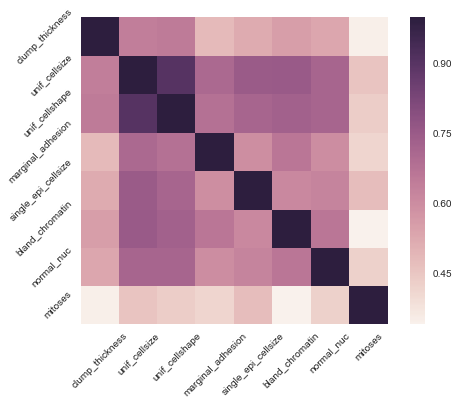

In [6]:
#load data
data=loaddata()

#use heatermap to look at the feature correlation
plt.figure()
sns.heatmap(data.iloc[:,:-1].corr(),square=True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

,clump_thickness,label
clump_thickness,1.000000,0.716001
label,0.716001,1.000000


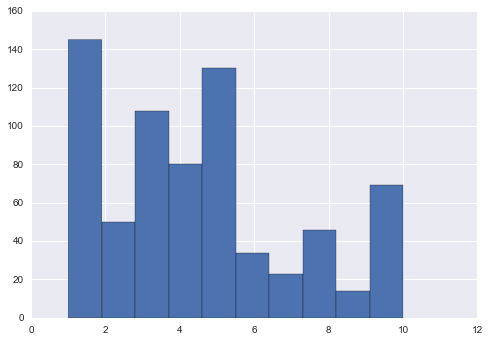

In [7]:
#uniform distribution of clump thickness
#strong correlation with label
plt.hist(data.clump_thickness)
data[['clump_thickness','label']].corr()

,unif_cellsize,label
unif_cellsize,1.000000,0.817904
label,0.817904,1.000000


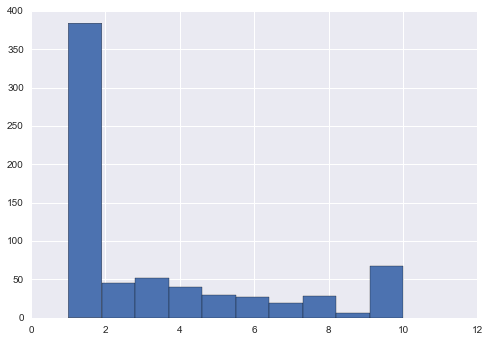

In [5]:
#skewed distribution of uniformity cell size
#strong correlation with label
plt.hist(data.unif_cellsize)
data[['unif_cellsize','label']].corr()

,unif_cellshape,label
unif_cellshape,1.000000,0.818934
label,0.818934,1.000000


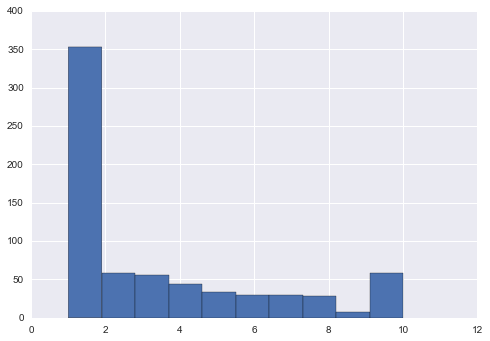

In [8]:
#skewed distribution of uniformity cells shape
#strong correlation with label
plt.hist(data.unif_cellshape)
data[['unif_cellshape','label']].corr()

## 3. Data processing
Logistic regression was used just for a baseline. Since features are correlated, I decided to use random forest.

In [9]:
def preprocess(data):
    #change label 2, 4 to 0,1
    data.label[data.label==2]=1
    data.label[data.label==4]=0

    #find out missing values and relace with NaN
    data=data.replace('?',np.nan)

    #examine the distribution of bare_nuclei
    data.bare_nuclei.describe()
  
    #fill missing values in bare_nuclei with the majority class 1
    data=data.fillna(1)
    data.bare_nuclei=data.bare_nuclei.astype('int64')
    
    #make a copy of data
    data1=data.copy()

    #log transform data with skewness larger than 0.5
    num_skew=data.iloc[:,:-1].apply(lambda x: skew(x))
    num_skew=num_skew[num_skew>0.5]
    num_skew = num_skew.index
    data[num_skew]=np.log1p(data[num_skew])
  
    return data,data1

## 4. Model
Use random forest considering the feature correlation. Use ROC, cross-validation, f to check the performance.

In [10]:
if __name__=='__main__':
    
    #load data
    data=loaddata()
  
    #preproces data
    data,data1=preprocess(data)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
    #prepare X and y
    X=data1.iloc[:,:-1]
    y=data1['label']
    
    #split data to train and test
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [12]:
    #build random forest classifier
    clf = RandomForestClassifier(n_estimators=10, random_state=42)
    solution=clf.fit(X_train,y_train)
    y_pred=solution.predict(X_test)

In [13]:
    #feature importance
    feature_importance=pd.DataFrame({'features': data1.iloc[:,:-1].columns, \
                                     'importance':solution.feature_importances_})
    feature_importance.sort_values(by='importance',ascending=False)

,features,importance
1,unif_cellsize,0.271467
2,unif_cellshape,0.173828
6,bland_chromatin,0.160202
5,bare_nuclei,0.140329
4,single_epi_cellsize,0.091269
7,normal_nuc,0.082931
0,clump_thickness,0.055947
3,marginal_adhesion,0.017339
8,mitoses,0.006686


In [14]:
    print "The f score is %f"%(f1_score(y_test,y_pred))

The f score is 0.984127


In [15]:
    #cross validation
    score=cross_val_score(clf,X,y,cv=3).mean()
    print score

0.964283319989


In [16]:
    #roc curve
    y_scores=pd.DataFrame(solution.predict_proba(X_test))[1]
    fpr,tpr,thresholds=roc_curve(y_test.ravel(),y_scores.ravel())

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


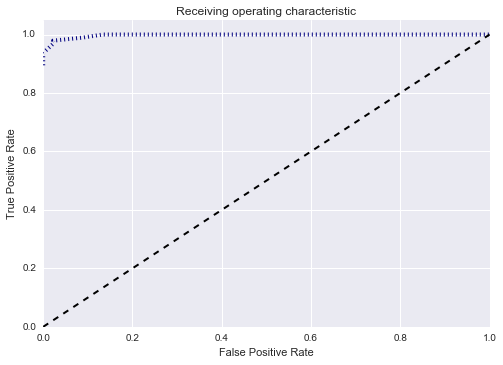

The AUC is 0.997661


In [17]:
    #plot roc curve
    plt.figure()
    plt.plot(fpr,tpr,linestyle=':',linewidth=4,color='navy')
    plt.plot([0,1],[0,1],'k--',lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiving operating characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
    print 'The AUC is %f'%(auc(fpr,tpr))


## 5. Conclusion
Uniformity of cell size and shape are the strongest predictors. Random forest did a good job predicting cancerous cells with an AUC of 99.8% and a f score of 0.98.